In [1]:
import torch
import clip
from PIL import Image
from utils import *
from tqdm import tqdm
from dataloader_comma import *
import json
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

/home/jessica/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
multitask = "distance"
dataset_type = 'train'
dataset = CommaDataset(dataset_type=dataset_type, multitask=multitask, return_full=True)
loader = DataLoader(dataset, batch_size=1, num_workers=5)
save_path = '/data3/jessica/data/toyota/explanation/'

In [3]:
scenarios = ["car in front changes the lane", "obstacle in front", 'another car in front', 'no car in front', 'a truck in front', 'truck in front changes the lane',
"bad weather", "good weather", 'poor visibility on the street', 'night driving',
"a lot of traffic", 'no traffic, free road', 'traffic jam',
'car megres into a new street', 'traffic light in front',
'bad road conditions', 'construction zone', 'road sign', 'pedestrian ahead', 'bicyle ahead', 
'a truck on the left', 'a truck on the right', 'a car on the left', 'a car on the right', ]
text = clip.tokenize(scenarios).to(device)
#text_features = model.encode_text(text)

7it [00:12,  1.55s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for

KeyboardInterrupt: 

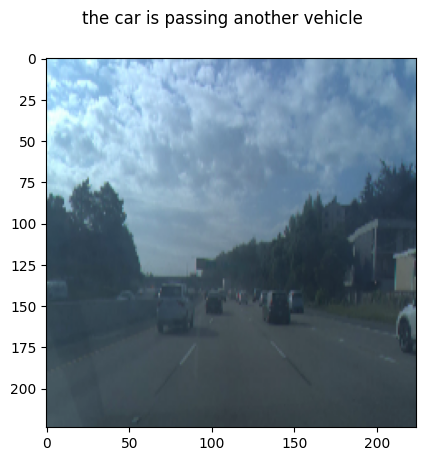

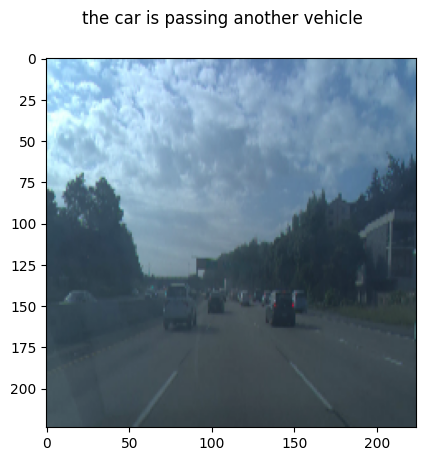

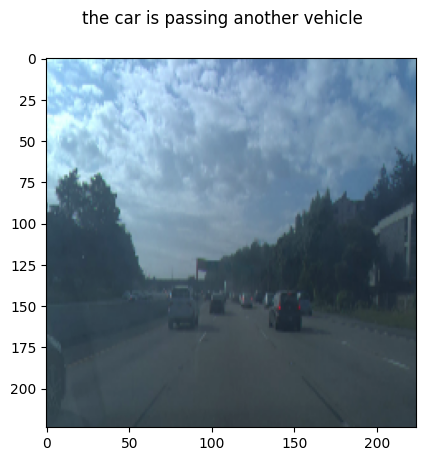

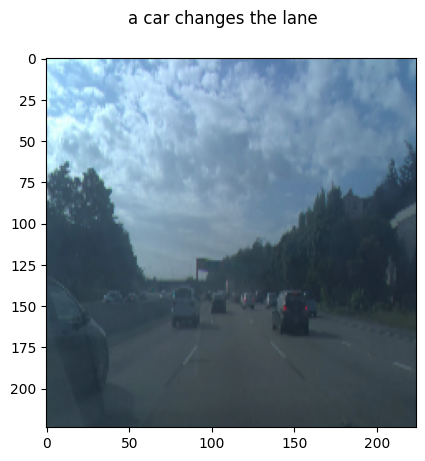

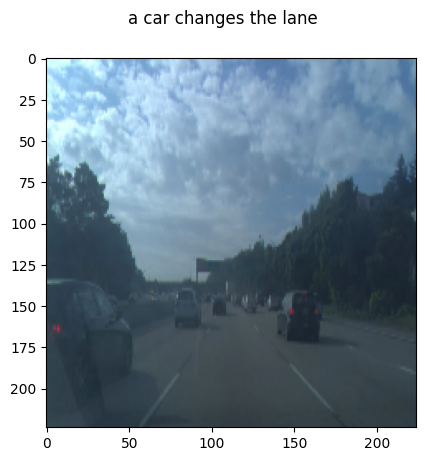

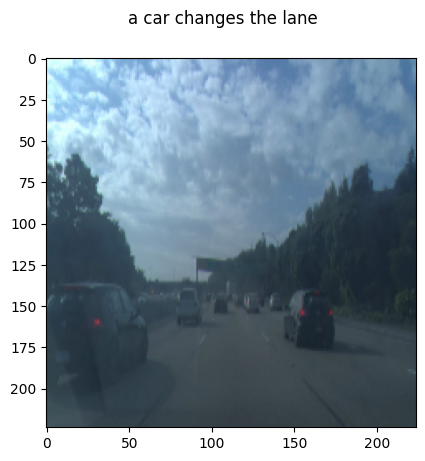

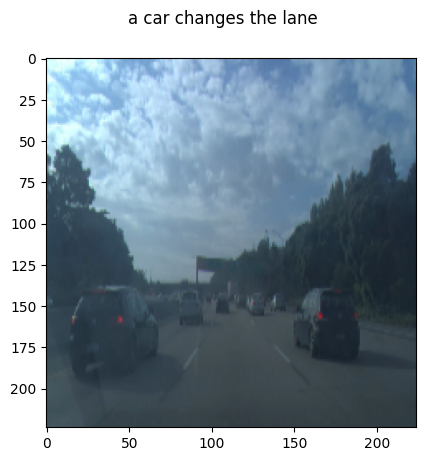

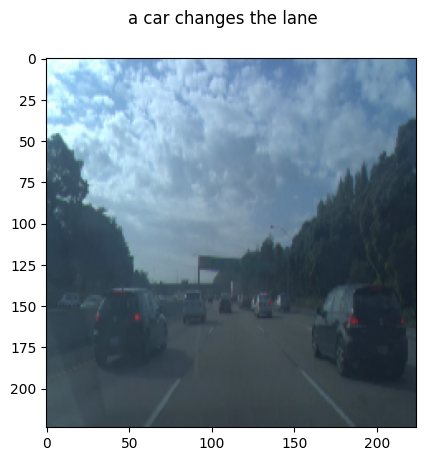

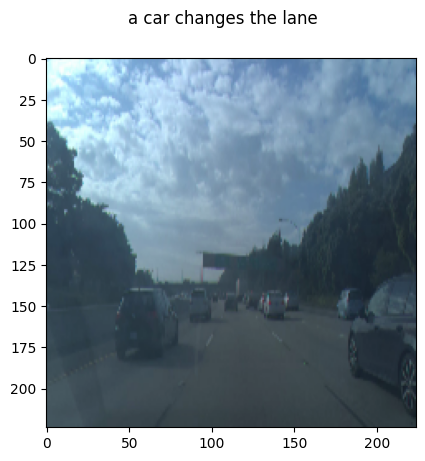

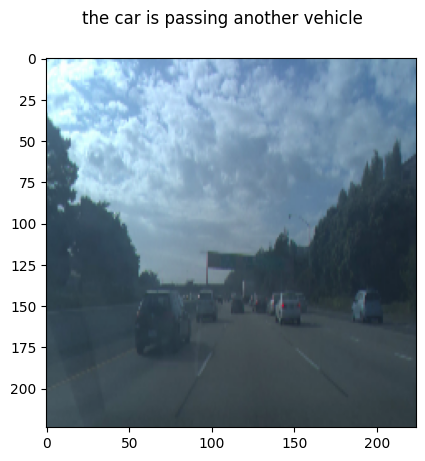

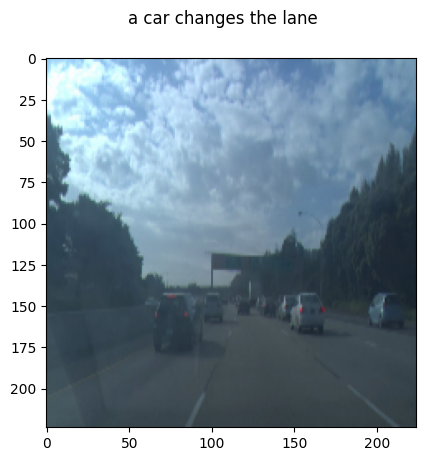

In [13]:
for j, batch in tqdm(enumerate(loader)):
    image_array, vego, angle, distance, gas, brake = batch
    intervention = gas | brake
    if intervention.sum() == 0: 
        continue
    
    images = image_array.squeeze()[intervention.squeeze().tolist()]
    if images.shape[0] == 0: 
        del image_array, vego, angle, distance, gas, brake
        continue

    for i, image in enumerate(images):
        fig, ax = plt.subplots()
        tensor = image.numpy().transpose((1, 2, 0))  # transpose tensor from C x H x W to H x W x C
        pil_image = Image.fromarray((tensor).astype('uint8'))
        img = preprocess(pil_image)
        logits_per_image, logits_per_text = model(img.unsqueeze(0), text)
        probs = logits_per_image.softmax(dim=-1).cpu().detach().numpy()
        ax.imshow(image.permute(1,2,0).int())
        fig.suptitle(scenarios[probs.argmax()])
        name = save_path + f"{i}_{j}" + "_image.png"

        fig.savefig(name)
        result_dict = {scenarios[i]: str(probs.squeeze()[i]) for i in range(len(scenarios))}
        with open(name.replace('_image.png', ".json"), 'w') as f:
            json.dump(result_dict, f)
    del image_array, vego, angle, distance, gas, brake


In [ ]:
p = '/data3/jessica/data/toyota/explanation/'
for elem in os.listdir(p):
    if elem[-5:] == ".json":
        with open(p + elem) as f:
            data = json.load(f)
    break
        

NameError: name 'os' is not defined

In [ ]:
data